In [1]:
from floppity import Retrieval, helpers
import numpy as np
import matplotlib.pyplot as plt
plt.rc('font', size=16)
import torch
# from corner import corner
from tqdm import trange
from floppity.simulators import read_ARCiS_input, ARCiS, mock_simulator

### Create simulator (function that takes parameters and returns spectra)

In [32]:
def gaussian(x, centers, sigmas, amplitudes):
    """Add multiple Gaussian features.

    Args:
        x (np.ndarray): Input x-axis (e.g., wavelengths).
        centers (list): List of Gaussian centers.
        sigmas (list): List of Gaussian standard deviations.
        amplitudes (list): List of Gaussian amplitudes.

    Returns:
        np.ndarray: Sum of all Gaussian features evaluated at x.
    """
    y = np.ones_like(x)
    for c, s, a in zip(centers, sigmas, amplitudes):
        y -= a * np.exp(-0.5 * ((x - c) / (s)) ** 2)
    return y

def simulator(obs, pars, thread=0):
    ndims=pars.shape[1]

    c=pars[:,0:ndims//3]
    s=pars[:,ndims//3:2*ndims//3]
    a=pars[:,2*ndims//3:3*ndims//3]
    
    x = {}
    for key in obs.keys():
        wvl = obs[key][:,0]
        x[key] = np.empty([len(c), len(wvl)])
        for i in trange(len(c)):
            x[key][i]=gaussian(wvl, c[i], s[i], a[i])
    return x

### Setup retrieval

In [2]:
R = Retrieval(mock_simulator)

### Get observation
R.get_obs(['/Users/floppityflappity/Work/FlopPITy/src/floppity/data/obs_simple.txt'])

### Add parameters
R.add_parameter('center', 1, 5)
R.add_parameter('sigma', 0.1, 0.7)
R.add_parameter('amplitude', 0, 1)

In [26]:
training_kwargs= dict(
    stop_after_epochs = 20,
    num_atoms = 10,
    learning_rate=5e-4
)

flow_kwargs=dict(
    flow='nsf',
    bins=8,
    transforms=5,
    blocks=2,
    hidden=32,
    dropout=0.25
)

### Run retrieval

In [27]:
R.run(flow_kwargs=flow_kwargs, resume=False, n_threads=4, training_kwargs=training_kwargs, n_rounds=1, n_samples=10000)

Starting training...
Round 1
 Neural network successfully converged after 270 epochs.
        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 270
        Best validation performance: -13.9888
        -------------------------
        


### Save retrieval object

In [25]:
R.save('/Users/floppityflappity/Work/R_50_3_5.pkl')

/opt/anaconda3/envs/venv/lib/python3.13/site-packages/cloudpickle/cloudpickle.py:1303: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  return super().dump(obj)


### Load retrieval object

In [4]:
R=Retrieval.load('r.pkl')

### Resume training

In [23]:
R.run(flow_kwargs=flow_kwargs, resume=True, n_threads=4, training_kwargs=training_kwargs, n_rounds=1, n_samples=100)

Resuming training...
Round 1


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 22 epochs.
        -------------------------
        ||||| ROUND 11 STATS |||||:
        -------------------------
        Epochs trained: 22
        Best validation performance: -4.8049
        -------------------------
        


### Plot loss evolution

Text(0, 0.5, 'Loss')

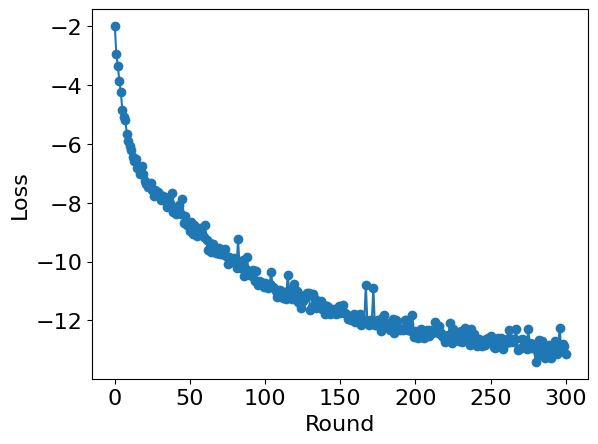

In [23]:
plt.plot(R.inference._summary['validation_loss'], marker='o', label=f'{len(R.proposals)}x{R.n_samples}')
plt.xlabel('Round')
plt.ylabel('Loss')

### Plot posterior

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

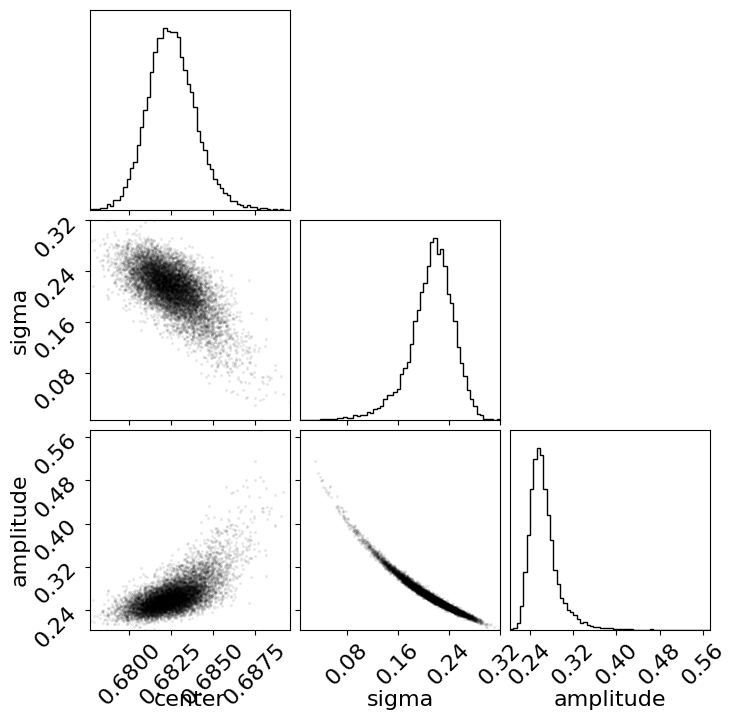

In [24]:
CORNER_KWARGS=dict(
    plot_density=False,
    hist_bin_factor=3,
    plot_contours=False,
)
fig=R.plot_corner(n_samples=10000,**CORNER_KWARGS)

## Posterior diagnostics

### Posterior predictive check

100%|██████████| 100/100 [00:00<00:00, 2673.42it/s]


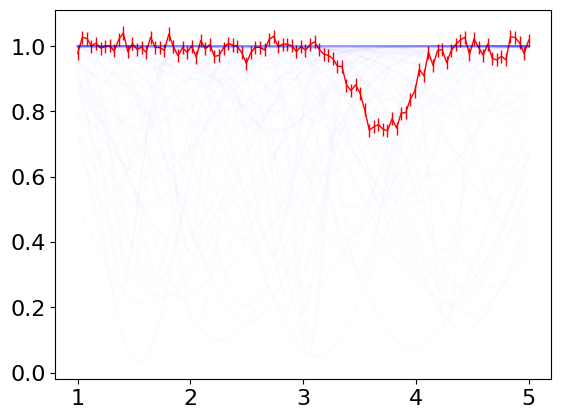

In [5]:
xs = R.post_x
# Xs=np.concatenate(list(xs.values()), axis=1)

# plt.figure(figsize=)
for key in R.obs.keys():
    plt.errorbar(x=R.obs[key][:,0], y=R.obs[key][:,1], yerr=R.obs[key][:,2], c='r', lw=1, zorder=0)
for i in trange(len(xs[0])):
    for key in R.obs.keys():
        plt.plot(R.obs[key][:,0], xs[key][i], c='b', alpha=0.01, zorder=1)
# plt.xlim(1.5,3.5)
# plt.ylim(0.5,1.05)

Drawing 1 posterior samples: 8032it [00:00, 18296.04it/s]
Drawing 1000 posterior samples: 1099it [00:00, 13364.78it/s]            
Drawing 1000 posterior samples: 1101it [00:00, 13151.62it/s]            
Drawing 1000 posterior samples: 1095it [00:00, 13246.05it/s]            
Drawing 1000 posterior samples: 1099it [00:00, 13331.54it/s]            
Drawing 1000 posterior samples: 1105it [00:00, 13417.36it/s]            
Drawing 1000 posterior samples: 1093it [00:00, 12394.66it/s]            
Drawing 1000 posterior samples: 1082it [00:00, 13802.89it/s]            
Drawing 1000 posterior samples: 1120it [00:00, 13339.64it/s]            
Drawing 1000 posterior samples: 1107it [00:00, 12877.81it/s]            
Drawing 1000 posterior samples: 1080it [00:00, 12755.86it/s]            
Drawing 1 posterior samples: 100%|██████████| 1/1 [00:00<00:00, 66.44it/s]
Drawing 1000 posterior samples: 1083it [00:00, 14180.78it/s]            
Drawing 1000 posterior samples: 1080it [00:00, 15195.43it/s]    

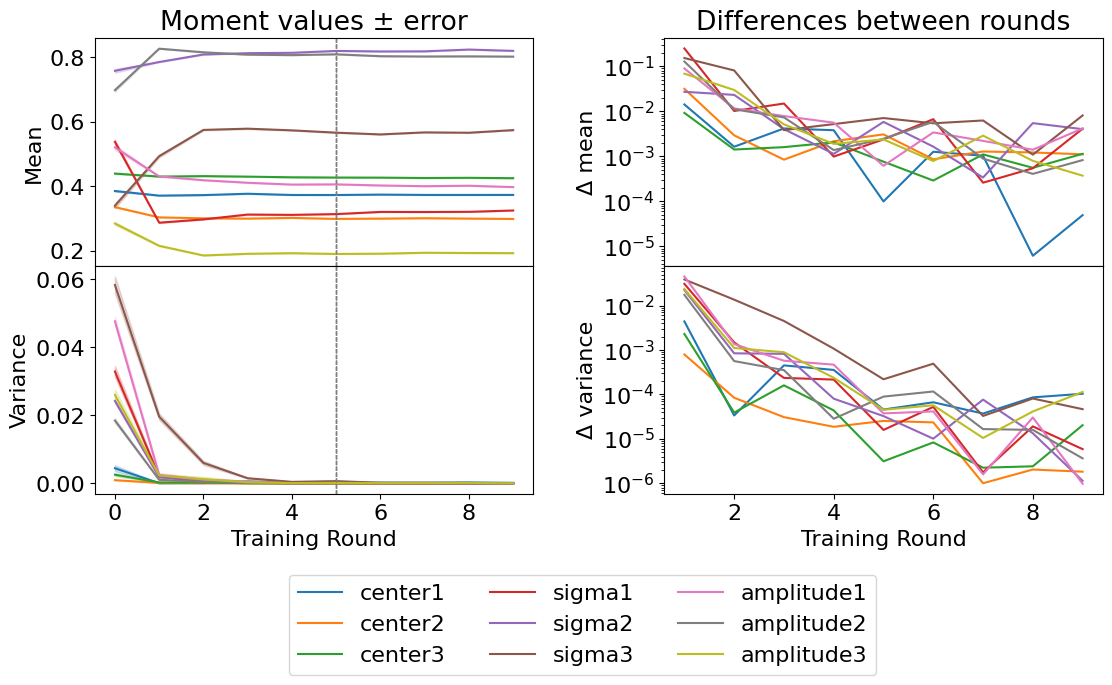

In [ ]:
plot_moment_evolution(R[0].proposals[:], 5, compute_moments, R=R[0], num_repeats=10, sample_size=1000)